In [2]:
# Import the packages here
import pandas as pd
import numpy as np
from numpy.linalg import inv
from scipy.optimize import minimize
import edhec_risk_ins as eri #obtained from cousera
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [75]:
# Calculate the monthly return
def monthly_return(sheet_name = 0):
    data = pd.read_excel("Equity_data.xlsx", sheet_name, index_col=0, header=0)
    daily_return = data.pct_change().dropna()
    monthly_return = daily_return.resample("M").apply(eri.compound)
    monthly_return.index = pd.to_datetime(monthly_return.index, format="%Y%m").to_period('M')
    return_list = ["Healthcare", "IT", "Financials", "Consumer Discretionary", "Industrials", "Communications", "Consumer Staple", "Materials", "Energy", "Utilities", "Real Estate"]
    monthly_return.columns = [return_list[sheet_name]]
    return monthly_return

In [76]:
df55 = pd.DataFrame()
for i in range(11):
    df55 = pd.concat([df55,monthly_return(i)],axis=1)
df55

,Healthcare,IT,Financials,Consumer Discretionary,Industrials,Communications,Consumer Staple,Materials,Energy,Utilities,Real Estate
Date,,,,,,,,,,,
2011-10,0.036693,0.107290,0.088728,0.099079,0.104518,0.055678,0.036553,0.108724,0.148800,0.010764,0.102854
2011-11,0.004561,-0.021414,-0.058801,-0.024891,-0.008812,-0.027502,0.016675,-0.013976,0.009610,-0.002469,-0.051246
2011-12,0.040102,-0.014935,0.007975,-0.000922,0.008932,0.000895,0.022819,-0.037516,-0.001053,0.003780,0.003167
2012-01,0.016655,0.068070,0.075258,0.068494,0.065572,-0.024320,-0.017206,0.096474,0.016362,-0.020797,0.074061
2012-02,0.012673,0.073788,0.056069,0.066674,0.042075,0.028043,0.039972,0.017712,0.047426,0.019448,0.034910
...,...,...,...,...,...,...,...,...,...,...,...
2021-05,0.015222,-0.012930,0.038669,-0.014985,0.022012,-0.002242,0.021242,0.032219,0.037007,-0.017290,0.010670
2021-06,0.037233,0.071988,-0.023574,0.030722,-0.005541,0.022751,0.007344,-0.026383,0.040964,-0.021633,0.023158
2021-07,0.034235,0.035057,-0.002027,0.001400,0.011081,0.018308,0.008689,0.030089,-0.062500,0.029052,0.036209


In [77]:
# Transform to column vector
def as_colvec(x):
    if (x.ndim == 2):
        return x
    else:
        return np.expand_dims(x, axis=1)
    
def portfolio_return(weights,returns):
    """
    weights -> returns
    """
    return weights.T @ returns
#first transpose the weights vector and then multiply by return vector

In [78]:
def annualize_rets(r,periods_per_year):
    """
    Annualized a set of returns 
    We should infer the periods per year
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def implied_returns(delta, sigma, w):
    """
Obtain the implied expected returns by reverse engineering the weights
Inputs:
delta: Risk Aversion Coefficient (scalar)
sigma: Variance-Covariance Matrix (N x N) as DataFrame
    w: Portfolio weights (N x 1) as Series
Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() # to get a series from a 1-column dataframe
    ir.name = 'Implied Returns'
    return ir

In [79]:
# Assumes that Omega is proportional to the variance of the prior
def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    Inputs:
    sigma: N x N Covariance Matrix as DataFrame
    tau: a scalar
    p: a K x N DataFrame linking Q and Assets
    returns a P x P DataFrame, a Matrix representing Prior Uncertainties
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    # Make a diag matrix from the diag elements of Omega
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)

In [80]:
from numpy.linalg import inv
def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta=1.5, tau=.02):
    """
# Computes the posterior expected returns based on 
# the original black litterman reference model
#
# W.prior must be an N x 1 vector of weights, a Series
# Sigma.prior is an N x N covariance matrix, a DataFrame
# P must be a K x N matrix linking Q and the Assets, a DataFrame
# Q must be an K x 1 vector of views, a Series
# Omega must be a K x K matrix a DataFrame, or None
# if Omega is None, we assume it is
#    proportional to variance of the prior
# delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    # Force w.prior and Q to be column vectors
    # How many assets do we have?
    N = w_prior.shape[0]
    # And how many views?
    K = q.shape[0]
    # First, reverse-engineer the weights to get pi
    pi = implied_returns(delta, sigma_prior,  w_prior)
    # Adjust (scale) Sigma by the uncertainty scaling factor
    sigma_prior_scaled = tau * sigma_prior  
    # posterior estimate of the mean, use the "Master Formula"
    # we use the versions that do not require
    # Omega to be inverted (see previous section)
    # this is easier to read if we use '@' for matrixmult instead of .dot()
    #     mu_bl = pi + sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ (q - p @ pi)
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    # posterior estimate of uncertainty of mu.bl
    #sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ p @ sigma_prior_scaled
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)

Set our views:
The IT industry will outperform the Financials industry 3% and the Communication services industry will outperform the energy 5%.


In [81]:
# for convenience and readability, define the inverse of a dataframe
def inverse(d):
    """
    Invert the dataframe by inverting the underlying matrix
    """
    return pd.DataFrame(inv(d.values), index=d.columns, columns=d.index)

def w_msr(sigma, mu, scale=True):
    """
    Optimal (Tangent/Max Sharpe Ratio) Portfolio weights
    by using the Markowitz Optimization Procedure
    Mu is the vector of Excess expected Returns
    Sigma must be an N x N matrix as a DataFrame and Mu a column vector as a Series
    This implements page 188 Equation 5.2.28 of
    "The econometrics of financial markets" Campbell, Lo and Mackinlay.
    """
    w = inverse(sigma).dot(mu)
    if scale:
        w = w/sum(w) # fix: this assumes all w is +ve
    return w

In [82]:
#Calculate the covmatrix - Sigma prior
covmatrix = df55.cov()*12
covmatrix

,Healthcare,IT,Financials,Consumer Discretionary,Industrials,Communications,Consumer Staple,Materials,Energy,Utilities,Real Estate
Healthcare,0.013815,0.012248,0.011695,0.012849,0.011947,0.010237,0.008217,0.011109,0.011671,0.006247,0.009877
IT,0.012248,0.025384,0.018570,0.021404,0.018916,0.014443,0.009490,0.018600,0.018937,0.006491,0.012852
Financials,0.011695,0.018570,0.027115,0.020775,0.021546,0.014693,0.008490,0.019541,0.026821,0.006314,0.014741
Consumer Discretionary,0.012849,0.021404,0.020775,0.023135,0.019962,0.015284,0.009825,0.018871,0.021882,0.006646,0.014077
Industrials,0.011947,0.018916,0.021546,0.019962,0.021370,0.013913,0.009424,0.019403,0.023554,0.006792,0.013644
Communications,0.010237,0.014443,0.014693,0.015284,0.013913,0.018763,0.009405,0.013178,0.018552,0.008349,0.012792
Consumer Staple,0.008217,0.009490,0.008490,0.009825,0.009424,0.009405,0.010331,0.007240,0.009614,0.007933,0.009218
Materials,0.011109,0.018600,0.019541,0.018871,0.019403,0.013178,0.007240,0.024604,0.023784,0.005488,0.012572
Energy,0.011671,0.018937,0.026821,0.021882,0.023554,0.018552,0.009614,0.023784,0.049213,0.006667,0.016435
Utilities,0.006247,0.006491,0.006314,0.006646,0.006792,0.008349,0.007933,0.005488,0.006667,0.013181,0.010473


In [83]:
# Mkt capitalization
sector_list = ["Healthcare", "IT", "Financials", "Consumer Discretionary", "Industrials", "Communications", "Consumer Staple", "Materials", "Energy", "Utilities", "Real Estate"]
mkt_cap = pd.Series([.128, .2281,.1341,.1174,.1045,.0927,.0689,.0431,.0279,.0278,.0274],index = sector_list)
mkt_cap

Healthcare                0.1280
IT                        0.2281
Financials                0.1341
Consumer Discretionary    0.1174
Industrials               0.1045
Communications            0.0927
Consumer Staple           0.0689
Materials                 0.0431
Energy                    0.0279
Utilities                 0.0278
Real Estate               0.0274
dtype: float64

In [84]:
#Compute implied returns from the Market cap weights assuming equilibrium in the mkt
pi = implied_returns(delta=1.5,sigma=covmatrix,w=mkt_cap)
pi

Healthcare                0.017477
IT                        0.027289
Financials                0.027264
Consumer Discretionary    0.027305
Industrials               0.025958
Communications            0.020818
Consumer Staple           0.013695
Materials                 0.024704
Energy                    0.029785
Utilities                 0.010520
Real Estate               0.019291
Name: Implied Returns, dtype: float64

### Absolute views

In [324]:
#our absolute outlook views for the sectors
#for instance, we expect healthcare will increase 5%
expectations = pd.Series([.05,.06,.045,.055,.01,0.05,0.035,0.35,0.03,0.03,0.035],index=sector_list)
expectations

Healthcare                0.050
IT                        0.060
Financials                0.045
Consumer Discretionary    0.055
Industrials               0.010
Communications            0.050
Consumer Staple           0.035
Materials                 0.350
Energy                    0.030
Utilities                 0.030
Real Estate               0.035
dtype: float64

In [325]:
#The Pick Matrix
#Absolute views
p = pd.DataFrame([
    {'Healthcare':1, 'IT':0, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":0},
    {"Healthcare":0, "IT":1, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":0},
    {"Healthcare":0, "IT":0, "Financials":1, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":0},
    {"Healthcare":0, "IT":0, "Financials":0, "Consumer Discretionary":1, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":0},
    {"Healthcare":0, "IT":0, "Financials":0, "Consumer Discretionary":0, "Industrials":1, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":0},
    {"Healthcare":0, "IT":0, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":1, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":0},
    {"Healthcare":0, "IT":0, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":1, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":0},
    {"Healthcare":0, "IT":0, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":1, "Energy":0, "Utilities":0, "Real Estate":0},
    {"Healthcare":0, "IT":0, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":1, "Utilities":0, "Real Estate":0},
    {"Healthcare":0, "IT":0, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":1, "Real Estate":0},
    {"Healthcare":0, "IT":0, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":1},
    ])
p

,Healthcare,IT,Financials,Consumer Discretionary,Industrials,Communications,Consumer Staple,Materials,Energy,Utilities,Real Estate
0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,0,0,0,1,0


In [326]:
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=mkt_cap, sigma_prior=covmatrix, p=p, q=expectations)
# Black Litterman Implied Mu
bl_mu

Healthcare                0.048277
IT                        0.076713
Financials                0.065977
Consumer Discretionary    0.072373
Industrials               0.073488
Communications            0.051192
Consumer Staple           0.027408
Materials                 0.126216
Energy                    0.078057
Utilities                 0.024494
Real Estate               0.046593
dtype: float64

In [327]:
# adjusted weights obtained with our absolute views
bl_weights = w_msr(bl_sigma, bl_mu)
bl_weights

Healthcare                0.063669
IT                       -0.060335
Financials               -0.112068
Consumer Discretionary   -0.111521
Industrials              -0.549125
Communications            0.015356
Consumer Staple           0.163405
Materials                 1.799685
Energy                   -0.182758
Utilities                 0.090400
Real Estate              -0.116708
dtype: float64

In [328]:
exp_re = portfolio_return(bl_weights,bl_mu)
exp_re

0.1575507620743726

In [19]:
np.sum(bl_weights)

1.0

### Absolute + Relative views

In [85]:
# Absolute Health 8.9%
# Abs IT 8.02%
# Abso Utilities 7%
# Relative Financials outperforme Real estate by 6%
# CD outperform CSple 3%
# Communications optperform energy 5%
# Materials 4%
views_q = pd.Series([
    # Relative view 1
    .089,
    # relative view 2
    .0802,
    #3
    .07,
    #4
    .06,
    .03,
    .05,
    .04])
views_q

0    0.0890
1    0.0802
2    0.0700
3    0.0600
4    0.0300
5    0.0500
6    0.0400
dtype: float64

In [86]:
p_new = pd.DataFrame([
    {'Healthcare':1, 'IT':0, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":0},
    {"Healthcare":0, "IT":1, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":0},
    {"Healthcare":0, "IT":0, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":1, "Real Estate":0},
    {'Healthcare':0, 'IT':0, "Financials":1, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":-1},
    {'Healthcare':0, 'IT':0, "Financials":0, "Consumer Discretionary":1, "Industrials":0, "Communications":0, "Consumer Staple":-1, "Materials":0, "Energy":0, "Utilities":0, "Real Estate":0},
    {'Healthcare':0, 'IT':0, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":1, "Consumer Staple":0, "Materials":0, "Energy":-1, "Utilities":0, "Real Estate":0},
    {'Healthcare':0, 'IT':0, "Financials":0, "Consumer Discretionary":0, "Industrials":0, "Communications":0, "Consumer Staple":0, "Materials":1, "Energy":0, "Utilities":0, "Real Estate":0}])

In [87]:
p_new

,Healthcare,IT,Financials,Consumer Discretionary,Industrials,Communications,Consumer Staple,Materials,Energy,Utilities,Real Estate
0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,-1
4,0,0,0,1,0,0,-1,0,0,0,0
5,0,0,0,0,0,1,0,0,-1,0,0
6,0,0,0,0,0,0,0,1,0,0,0


In [88]:
bl_mu_relative, bl_sigma_relative = bl(w_prior=mkt_cap, sigma_prior=covmatrix, p=p_new, q=views_q)
# Black Litterman Implied Mu
bl_mu_relative

Healthcare                0.059746
IT                        0.072227
Financials                0.073380
Consumer Discretionary    0.072263
Industrials               0.066812
Communications            0.061614
Consumer Staple           0.044277
Materials                 0.054849
Energy                    0.048000
Utilities                 0.042646
Real Estate               0.047448
dtype: float64

In [89]:
bl_sigma_relative

,Healthcare,IT,Financials,Consumer Discretionary,Industrials,Communications,Consumer Staple,Materials,Energy,Utilities,Real Estate
Healthcare,0.013924,0.012296,0.011748,0.012911,0.012003,0.010291,0.008270,0.011149,0.011719,0.006274,0.009928
IT,0.012296,0.025558,0.018646,0.021516,0.019006,0.014517,0.009551,0.018673,0.019009,0.006519,0.012913
Financials,0.011748,0.018646,0.027329,0.020889,0.021682,0.014797,0.008552,0.019626,0.026986,0.006361,0.014871
Consumer Discretionary,0.012911,0.021516,0.020889,0.023286,0.020073,0.015383,0.009903,0.018948,0.021996,0.006683,0.014167
Industrials,0.012003,0.019006,0.021682,0.020073,0.021520,0.013999,0.009495,0.019499,0.023688,0.006833,0.013739
Communications,0.010291,0.014517,0.014797,0.015383,0.013999,0.018976,0.009482,0.013245,0.018736,0.008404,0.012891
Consumer Staple,0.008270,0.009551,0.008552,0.009903,0.009495,0.009482,0.010440,0.007272,0.009690,0.007986,0.009285
Materials,0.011149,0.018673,0.019626,0.018948,0.019499,0.013245,0.007272,0.024771,0.023898,0.005512,0.012637
Energy,0.011719,0.019009,0.026986,0.021996,0.023688,0.018736,0.009690,0.023898,0.049654,0.006715,0.016562
Utilities,0.006274,0.006519,0.006361,0.006683,0.006833,0.008404,0.007986,0.005512,0.006715,0.013296,0.010546


In [90]:
#Adjusted relative views weights
adj_bl_weights = w_msr(bl_sigma_relative, bl_mu_relative)
adj_bl_weights

Healthcare                0.426908
IT                        0.122460
Financials                0.433766
Consumer Discretionary    0.059887
Industrials               0.028634
Communications            0.242374
Consumer Staple          -0.008838
Materials                -0.097226
Energy                   -0.209328
Utilities                 0.390876
Real Estate              -0.389513
dtype: float64

In [91]:
exp_r = portfolio_return(adj_bl_weights,bl_mu_relative)
exp_r

0.06977118950665001

## Plot

In [20]:
def portfolio_vol(weights,covmatrix):
    """
    weights -> vol
    """
    return (weights.T @ covmatrix @ weights)**0.5

In [21]:
## Function needed to plot
def msr(riskfree_rate,er,cov):
    """
    Riskfree_rate + er + cov -> Weights Vector
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n,n)
    bounds = ((0.01, 0.7),)*n 
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights: np.sum(weights)-1   
    }
    def neg_sharp_ratio(weights,riskfree_rate,er,cov):
        """
        Returns the nagative of the sharp ratio, given weights
        """
        r = portfolio_return(weights,er)
        vol = portfolio_vol(weights,cov)
        return -(r-riskfree_rate)/vol
    results = minimize(neg_sharp_ratio,init_guess,
                       args=(riskfree_rate, er, cov,), method="SLSQP",
                       options={'disp':False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return results.x

def gmv(cov):
    """
    Returns the weight of the Global Minmum Vol Portfolio
    given the cov matrix
    """
    n = cov.shape[0]
    return msr(0,np.repeat(1,n),cov)

def minimize_vol(target_return,er,cov):
    """
    target_return -> Weights Vector
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n,n)
    bounds = ((0.0,1),)*n #
    return_is_target = { #notice the usage of curly brackets
        'type':'eq', #"eq" type means the function below is 0."ineq" means different from 0 
        'args':(er,), #need to specify a new parameter in order to operate the function "portfolio_return"
        'fun': lambda weights,er:target_return - portfolio_return(weights,er)
    }
    weights_sum_to_1 = {
        'type':'eq',
        'fun':lambda weights: np.sum(weights)-1   
    }
    results = minimize(portfolio_vol,init_guess,
                       args=(cov,),method="SLSQP",
                       options={'disp':False},
                       constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds
                      )
    return results.x

In [93]:
def plot_ef(n_points,er,cov,w_prior, p, q,show_cml=False,riskfree_rate=0.0015, show_ew=False,show_gmv=False):
    """
    plots the multi-asset Black-litterman efficient frontier
    er: implied returns - pi
    cov: sigma_prior - covmatrix
    w_prior:mkt_cap
    riskfree_rate defaulted as 0.15%
    """
    target_rets = np.linspace(er.min(),er.max(),n_points)
    weights = [minimize_vol(target_return,er,cov) for target_return in target_rets]
    rets = [portfolio_return(w,er) for w in weights]
    vols = [portfolio_vol(w,cov) for w in weights]
    ef1 = pd.DataFrame({
        "Implied Returns EF":rets,
        "Volatility":vols
    })
    ax1 = ef1.plot.line(x="Volatility", y="Implied Returns EF", style=".-",figsize=(10,6),color='blue')
    
    bl_mu, bl_sigma = bl(w_prior=w_prior, sigma_prior=cov, p=p, q=q)
    target_rets2 = np.linspace(bl_mu.min(),bl_mu.max(),n_points)
    weights2 = [minimize_vol(target_return,bl_mu,bl_sigma) for target_return in target_rets2]
    rets2 = [portfolio_return(w,bl_mu) for w in weights2]
    vols2 = [portfolio_vol(w,bl_sigma) for w in weights2]
    
    ef2 = pd.DataFrame({
        "Black-Litterman Adjusted EF":rets2,
        "Volatility":vols2
    })
    ax2 = ef2.plot.line(x="Volatility", y="Black-Litterman Adjusted EF", style=".-",figsize=(10,6),color='blue')
    
    if show_ew:
        n=er.shape[0]
        w_ew = np.repeat(1/n,n)
        r_ew = portfolio_return(w_ew,er)
        vol_ew = portfolio_vol(w_ew,cov)
        #display ew
        ax1.plot([vol_ew],[r_ew],color="goldenrod",marker="o",markersize=8)
        #ax.plot(X-axis,Y-axis)
        r_ew2 = portfolio_return(w_ew,bl_mu)
        vol_ew2 = portfolio_vol(w_ew,bl_sigma)
        ax2.plot([vol_ew2],[r_ew2],color="goldenrod",marker="o",markersize=8)
        
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv,er)
        vol_gmv = portfolio_vol(w_gmv,cov)
        #display gmv
        ax1.plot([vol_gmv],[r_gmv],color="midnightblue",marker="o",markersize=8)
        
        w_gmv2 = gmv(bl_sigma)
        r_gmv2 = portfolio_return(w_gmv2,bl_mu)
        vol_gmv2 = portfolio_vol(w_gmv2,bl_sigma)
        #display gmv
        ax2.plot([vol_gmv2],[r_gmv2],color="midnightblue",marker="o",markersize=8)
        
        
    if show_cml:
        ax1.set_xlim(left = 0)
        wts_msr = msr(riskfree_rate,er,cov)
        r_msr = portfolio_return(wts_msr, er)
        vol_msr = portfolio_vol(wts_msr, cov)
        # Add CML
        cml_x = [0,vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax1.plot(cml_x, cml_y, color="green", marker="o",linestyle="dashed", markersize=10,linewidth=2)
        
        # ax2
        ax2.set_xlim(left = 0)
        # When leverage is allowed
        #wts_bl = w_msr(sigma=bl_sigma,mu=bl_mu)
        #r_bl = portfolio_return(wts_bl, bl_mu)
        #vol_bl = portfolio_vol(wts_bl, bl_sigma)
        
        # whenleverage not allowed
        wts_bl2 = msr(riskfree_rate,bl_mu,bl_sigma)
        r_bl2 = portfolio_return(wts_bl2, bl_mu)
        vol_bl2 = portfolio_vol(wts_bl2, bl_sigma)
        cml_x2 = [0,vol_bl2]
        cml_y2 = [riskfree_rate, r_bl2]
        ax2.plot(cml_x2, cml_y2, color="green", marker="o",linestyle="dashed", markersize=8,linewidth=2) 
        
    return ax1,ax2

(<matplotlib.axes._subplots.AxesSubplot at 0x1d46534cb08>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d4651d4c08>)

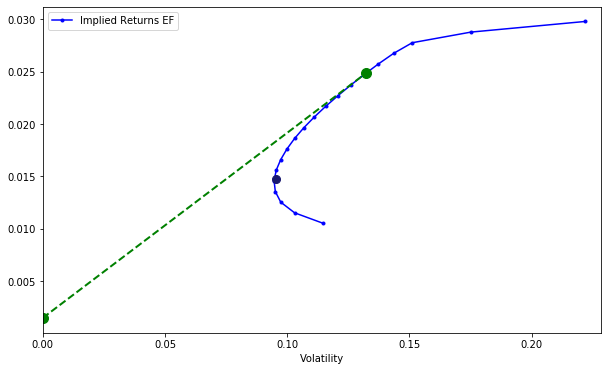

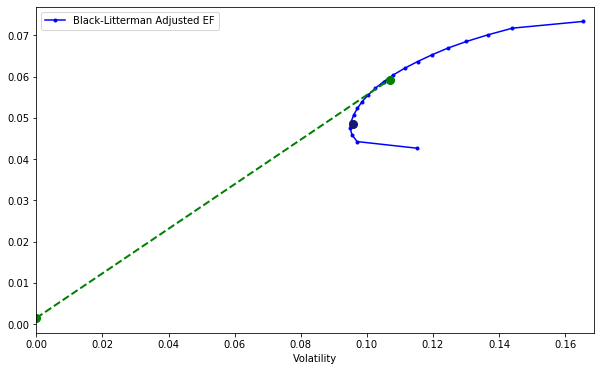

In [94]:
plot_ef(20,er=pi,cov = covmatrix,w_prior=mkt_cap, p=p_new, q=views_q,show_gmv=True,show_ew=False,show_cml=True)

the tangent point is higher in BL model 

In [143]:
# BL model calculate the optimal weights for equities which are not always positive, so we use another optimization function msr instead of w_msr to compute the weights
#If dont allow leverage and short
adjweights_bl = msr(riskfree_rate = 0.0015,er=bl_mu_relative,cov=bl_sigma_relative)
adjweights_bl

array([0.41169035, 0.11615139, 0.13374901, 0.01      , 0.01      ,
       0.06622769, 0.01      , 0.01      , 0.01      , 0.21218157,
       0.01      ])

In [96]:
# we can see the same on the Efficient frontier of BL 
e_r = portfolio_return(adjweights_bl,bl_mu_relative)
e_r

0.0592665239939623

In [97]:
port_ret_nonlev = adjweights_bl*df55

In [98]:
port_tt_rets_nonlev = pd.DataFrame(port_ret_nonlev.sum(axis='columns'))
port_tt_rets_nonlev.columns = ['EQ Non-Lvg Return']
port_tt_rets_nonlev

,EQ Non-Lvg Return
Date,
2011-10,0.051412
2011-11,-0.011546
2011-12,0.016657
2012-01,0.021843
2012-02,0.029758
...,...
2021-05,0.007201
2021-06,0.018156
2021-07,0.025521


In [99]:
#compute the downside risk
def semideviation(weights, r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a Dataframe
    """
    is_negative = r < 0
    covmatrix = r[is_negative].cov()
    return np.sqrt((weights.T @ covmatrix @ weights))*(12)**0.5

def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

In [100]:
def obj_sortino(rets):
    """
    Riskfree_rate + returns-> Weights Vector
    """
    riskfree_rate = 0.0015
    #covmatrix of returns 
    cov = rets.cov()*12
    #annulize the returns
    annu_r  = annualize_rets(rets,12)
    
    #find the number of assets
    n = annu_r.shape[0]
    init_guess = np.repeat(1/n,n)
    bounds = ((0.05, 0.3),)*n 
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights: np.sum(weights)-1   
    }
    def neg_sortino_ratio(weights,riskfree_rate,annu_r,cov):
        """
        Returns the nagative of the sharp ratio, given weights
        minimize the negative sharp ratio means maximize the sharp ratio 
        """
        r = portfolio_return(weights,annu_r)
        semi_vol = semideviation(weights,rets)
        return -(r-riskfree_rate)/semi_vol
        
    results = minimize(neg_sortino_ratio,init_guess,
                       args=(riskfree_rate,annu_r,cov),method="SLSQP",
                       options={'disp':False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return results.x


def obj_msr(rets):
    """
    Riskfree_rate + returns-> Weights Vector
    """
    riskfree_rate = 0.0015
    #covmatrix of returns 
    cov = rets.cov()*12
    #annulize the returns
    annu_r  = annualize_rets(rets,12)
    
    #find the number of assets
    n = annu_r.shape[0]
    init_guess = np.repeat(1/n,n)
    bounds = ((0.01, 0.99),)*n 
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights: np.sum(weights)-1   
    }
    def neg_sharp_ratio(weights,riskfree_rate,annu_r,cov):
        """
        Returns the nagative of the sharp ratio, given weights
        minimize the negative sharp ratio means maximize the sharp ratio 
        """
        r = portfolio_return(weights,annu_r)
        vol = portfolio_vol(weights,cov)
        return -(r-riskfree_rate)/vol
        
    results = minimize(neg_sharp_ratio,init_guess,
                       args=(riskfree_rate, annu_r, cov,), method="SLSQP",
                       options={'disp':False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return results.x

In [144]:
#load the other asset class data
col_names = ['US Corp Bond','US High Yield','US MBS','US GOV','Euro Aggregate','Pan-Euro HY','Asia-Pacific Aggre','EM USD','REITs']
prices = pd.read_csv(U"C:/Users/YUAN PUEN/Desktop/金融工程/JupyterLab/Data/Bond.csv", names=col_names, parse_dates=True,header=0,index_col=0)
prices.columns = prices.columns.str.strip()
prices = prices.dropna()
# prices = prices.iloc[:,:12]
rets = prices.pct_change().dropna()
rets.head(4)

,US Corp Bond,US High Yield,US MBS,US GOV,Euro Aggregate,Pan-Euro HY,Asia-Pacific Aggre,EM USD,REITs
2005-06-21,0.003080,0.002377,0.003144,0.004863,0.000110,0.002237,0.000473,0.001649,0.001860
2005-06-22,0.005821,0.001031,0.009985,-0.001113,-0.003131,0.001257,0.001072,0.001797,0.007687
2005-06-23,-0.000700,0.001532,0.001834,-0.003973,0.001594,0.001635,-0.000803,-0.000051,0.008974
2005-06-24,0.002328,0.000926,0.002549,0.005631,-0.000240,0.000937,-0.000175,0.001094,-0.014711


In [145]:
rets_m = rets.resample('M').apply(eri.compound).to_period('M')
rets_m = pd.DataFrame(rets_m)
rets_m = rets_m["2011-10":]
rets_m.head()

,US Corp Bond,US High Yield,US MBS,US GOV,Euro Aggregate,Pan-Euro HY,Asia-Pacific Aggre,EM USD,REITs
2011-10,0.017875,0.065826,0.010970,-0.001105,0.005846,-0.043964,0.000065,0.047666,0.075596
2011-11,-0.019599,-0.004607,-0.014800,-0.063835,-0.002938,-0.001430,0.001885,-0.012598,-0.037220
2011-12,0.021376,0.020658,0.022613,-0.009317,-0.003541,0.036512,0.005443,0.014366,0.059610
2012-01,0.022141,0.028724,0.020907,-0.146007,0.008312,-0.010453,0.009318,0.023426,0.061919
2012-02,0.008418,0.010163,0.015355,-0.063864,-0.004910,0.030913,-0.002041,0.027309,-0.006497


In [146]:
# ajouter la column de Non-Leveraged Equity return
rets_m_nonlev = pd.concat([rets_m,port_tt_rets_nonlev],axis=1)
rets_m_nonlev.head()

,US Corp Bond,US High Yield,US MBS,US GOV,Euro Aggregate,Pan-Euro HY,Asia-Pacific Aggre,EM USD,REITs,EQ Non-Lvg Return
2011-10,0.017875,0.065826,0.010970,-0.001105,0.005846,-0.043964,0.000065,0.047666,0.075596,0.051412
2011-11,-0.019599,-0.004607,-0.014800,-0.063835,-0.002938,-0.001430,0.001885,-0.012598,-0.037220,-0.011546
2011-12,0.021376,0.020658,0.022613,-0.009317,-0.003541,0.036512,0.005443,0.014366,0.059610,0.016657
2012-01,0.022141,0.028724,0.020907,-0.146007,0.008312,-0.010453,0.009318,0.023426,0.061919,0.021843
2012-02,0.008418,0.010163,0.015355,-0.063864,-0.004910,0.030913,-0.002041,0.027309,-0.006497,0.029758


In [167]:
# Idont want the AP aggregate asset
rets_m_new = rets_m_nonlev.iloc[:,0:6]
rets_m_new1 = rets_m_nonlev.iloc[:,7:]

In [149]:
# Data we use 
rets_m_new = pd.concat([rets_m_new,rets_m_new1],axis=1)
rets_m_new

,US Corp Bond,US High Yield,US MBS,US GOV,Euro Aggregate,Pan-Euro HY,EM USD,REITs,EQ Non-Lvg Return
2011-10,0.017875,0.065826,0.010970,-0.001105,0.005846,-0.043964,0.047666,0.075596,0.051412
2011-11,-0.019599,-0.004607,-0.014800,-0.063835,-0.002938,-0.001430,-0.012598,-0.037220,-0.011546
2011-12,0.021376,0.020658,0.022613,-0.009317,-0.003541,0.036512,0.014366,0.059610,0.016657
2012-01,0.022141,0.028724,0.020907,-0.146007,0.008312,-0.010453,0.023426,0.061919,0.021843
2012-02,0.008418,0.010163,0.015355,-0.063864,-0.004910,0.030913,0.027309,-0.006497,0.029758
...,...,...,...,...,...,...,...,...,...
2021-05,0.007682,0.003790,0.008401,0.014476,-0.011781,0.005148,0.009186,0.011744,0.007201
2021-06,0.016313,0.013165,0.016214,0.044927,0.000098,0.006922,0.007167,0.022143,0.018156
2021-07,0.013688,-0.001645,0.013588,0.013819,-0.006683,0.002086,0.001599,0.047149,0.025521
2021-08,-0.003025,0.008924,-0.000796,-0.050404,-0.001481,0.006439,0.009742,0.017732,0.031012


In [150]:
#Max sortino ratio strategy for non levraged equity portfolio
w_sortino_nonlev = obj_sortino(rets_m_new)
optim_sr_nonlev = w_sortino_nonlev / sum(w_sortino_nonlev)
optim_sr_nonlev

array([0.05      , 0.05      , 0.19219607, 0.14695796, 0.05      ,
       0.29097688, 0.05      , 0.05      , 0.11986909])

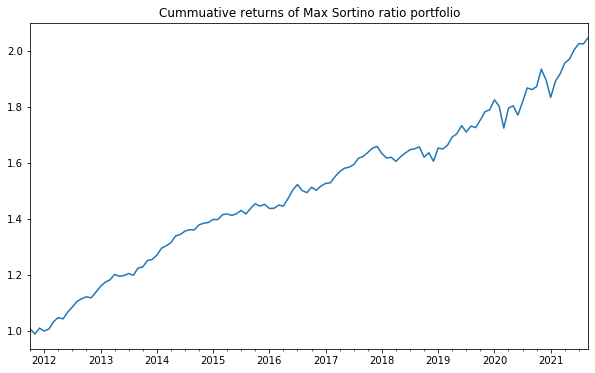

In [151]:
# cummulative returns obtained by Sortino strategy
port_sortino_nonlev = np.sum(optim_sr_nonlev * rets_m_new,axis = 1)
cumrets_sortino_nonlev = (1+port_sortino_nonlev).cumprod()
cumrets_sortino_nonlev.plot(figsize=(10,6),title = 'Cummuative returns of Max Sortino ratio portfolio')

In [152]:
port_sortino_nonlev = pd.DataFrame(port_sortino_nonlev)
port_sortino_nonlev.columns = ['Optimized Non-Lever Portfolio']

In [153]:
eri.Summary_Stats(port_sortino_nonlev,riskfree_rate=0.0015,periods_per_year = 12)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawdown
Optimized Non-Lever Portfolio,0.074269,0.045229,-0.618564,4.545177,0.017101,0.025922,1.606714,-0.055413


### Factor analysis

In [127]:
fff = pd.read_csv("C:/Users/YUAN PUEN/Desktop/金融工程/JupyterLab/Data/FF_5_Factors_M.csv",
                       header=0, index_col=0, na_values=-99.99)/100
fff.index = pd.to_datetime(fff.index, format="%Y%m").to_period('M')
fff.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
2021-04,0.0493,-0.0310,-0.0093,0.0230,-0.0279,0.0
2021-05,0.0029,0.0119,0.0704,0.0234,0.0310,0.0
2021-06,0.0279,-0.0025,-0.0776,-0.0214,-0.0099,0.0
2021-07,0.0119,-0.0456,-0.0175,0.0536,-0.0055,0.0
2021-08,0.0291,-0.0076,-0.0007,-0.0028,-0.0167,0.0


In [129]:
port_excess = port_sortino_nonlev["2011-10":"2021-08"] - fff.loc["2011-10":"2021-08",["RF"]].values
mkt_excess = fff.loc["2011-10":"2021-08",["Mkt-RF"]]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
exp_var["Value"] = fff.loc["2011-10":"2021-08",["HML"]]
exp_var["Size"] = fff.loc["2011-10":"2021-08",["SMB"]]
exp_var["Robust"] = fff.loc["2011-10":"2021-08",["RMW"]]
exp_var["Conservative"] = fff.loc["2011-10":"2021-08",["CMA"]]
exp_var.head()

,Mkt-RF,Constant,Value,Size,Robust,Conservative
2011-10,0.1135,1,0.0012,0.0348,-0.0215,-0.0087
2011-11,-0.0028,1,-0.0046,-0.0028,0.0183,0.0151
2011-12,0.0074,1,0.0161,-0.0033,0.0101,0.0249
2012-01,0.0505,1,-0.0094,0.0207,-0.0201,-0.0146
2012-02,0.0442,1,0.0043,-0.0171,-0.0047,-0.0004


In [131]:
lm = sm.OLS(port_excess,exp_var).fit()
print(lm.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Optimized Non-Lever Portfolio   R-squared:                       0.364
Model:                                       OLS   Adj. R-squared:                  0.336
Method:                            Least Squares   F-statistic:                     12.94
Date:                           Sun, 03 Oct 2021   Prob (F-statistic):           5.89e-10
Time:                                   15:20:52   Log-Likelihood:                 373.44
No. Observations:                            119   AIC:                            -734.9
Df Residuals:                                113   BIC:                            -718.2
Df Model:                                      5                                         
Covariance Type:                       nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------

- Interpretation: the result above implies that our portfolio appears to be a robust investor as the value coef is positive.The negative tilt on Size and value suggests that our portfolio tends to invest in large companies,not small companies. It is adding alpha of 0.41% per month and the significane is high, t>4

### Backtesting

In [168]:
def backtest_rolling(rets, obj_fun, estimation_window=12):
    """
    Backtests a given optimization scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    """
    n_periods = rets.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # for each estimation window
    weights = [obj_fun(rets.iloc[win[0]:win[1]]) for win in windows]
    # List -> DataFrame
    weights = pd.DataFrame(weights, index=rets.iloc[estimation_window-1:].index, columns=rets.columns)
    # return weights
    returns = (weights * rets).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns.dropna()

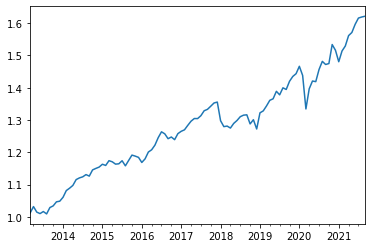

In [164]:
sortino_bt = backtest_rolling(rets = rets_m_new,obj_fun = obj_sortino)
sortino_cumr_bt = (1+sortino_bt).cumprod()
sortino_cumr_bt.plot()

In [165]:
eri.Summary_Stats(pd.DataFrame(sortino_bt),riskfree_rate=0.0015,periods_per_year = 12)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawdown
0,0.057934,0.05228,-1.358931,9.540061,0.023183,0.033527,1.077986,-0.090108


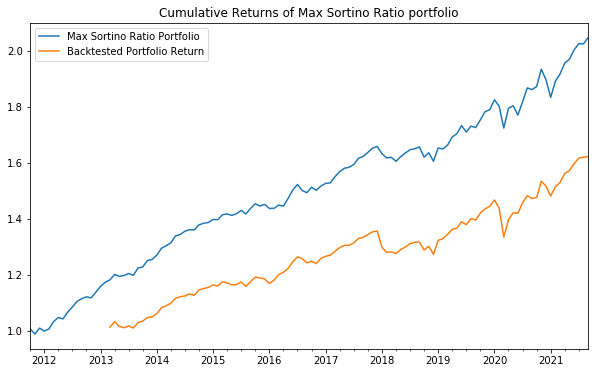

In [166]:
cumrets_sortino_nonlev.plot(figsize=(10,6),title = 'Cumulative Returns of Max Sortino Ratio portfolio',label='Max Sortino Ratio Portfolio',legend=True)
sortino_cumr_bt.plot(label='Backtested Portfolio Return',legend=True)

## Risk parity

In [115]:
def risk_contribution(weights,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, 
    given a set of portfolio weights and a covariance matrix
    """
    # Portfolio risk
    total_portfolio_var = weights.T @ cov @ weights
    # Marginal contribution of each constituent
    marginal_contrib = cov @ weights
    risk_contrib = np.multiply(marginal_contrib,weights.T)/total_portfolio_var
    return risk_contrib

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions 
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': True},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

#for backtesting
def erc(rets):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    covmatrix = rets.cov()
    n = covmatrix.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n
    target_risk=np.repeat(1/n,n)
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    
    def erc_risk(weights,cov,target_risk):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        cov = covmatrix
        total_portfolio_var = np.sqrt(weights.T @ cov @ weights)
        # Marginal contribution of each constituent
        marginal_contrib = cov @ weights
        risk_contrib = np.multiply(marginal_contrib,weights.T)/total_portfolio_var
        
        return ((risk_contrib-target_risk)**2).sum()
    
    weights = minimize(erc_risk, init_guess,
                       args = (covmatrix, target_risk), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions 
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

In [116]:
optim_w_rp = equal_risk_contributions(rets_m_new.cov())
optim_w_rp

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.1591188242570386e-07
            Iterations: 10
            Function evaluations: 118
            Gradient evaluations: 10


array([0.1310689 , 0.10408093, 0.1353037 , 0.08290102, 0.10523348,
       0.21748757, 0.10858474, 0.04307244, 0.07226722])

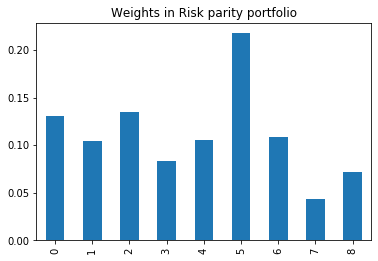

In [117]:
pd.Series(optim_w_rp).plot.bar(title='Weights in Risk parity portfolio')

In [118]:
risk_contribution(optim_w_rp, rets_m_new.cov())

US Corp Bond         0.111040
US High Yield        0.111456
US MBS               0.111012
US GOV               0.111124
Euro Aggregate       0.111205
Pan-Euro HY          0.110843
EM USD               0.111116
REITs                0.111123
EQ Non-Lvg Return    0.111081
dtype: float64

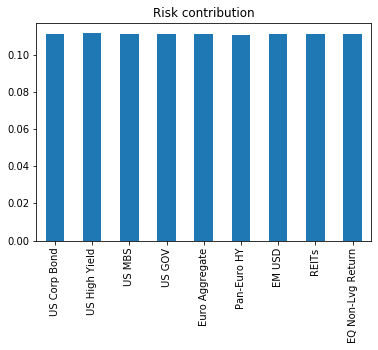

In [119]:
risk_contribution(optim_w_rp, rets_m_new.cov()).plot.bar(title="Risk contribution")

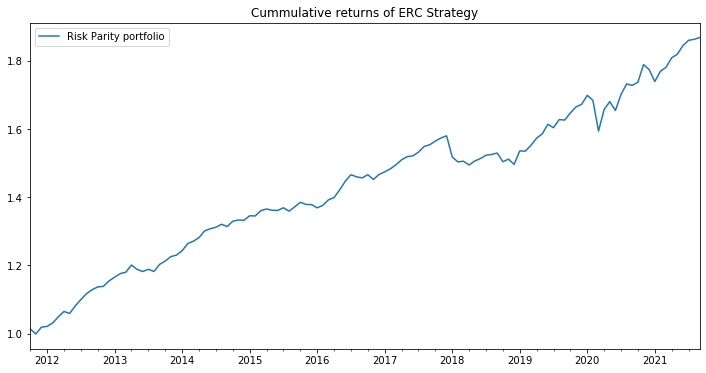

In [120]:
RP_port = np.sum(optim_w_rp * rets_m_new,axis = 1)
cumrets_RP = (1+RP_port).cumprod()
cumrets_RP.plot(figsize = (12,6),title = "Cummulative returns of ERC Strategy",label = 'Risk Parity portfolio',legend=True)

In [121]:
RP_p1 = pd.DataFrame(RP_port,columns=['RP'])
eri.Summary_Stats(RP_p1,riskfree_rate=0.0015, periods_per_year=12)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawdown
RP,0.064527,0.041089,-1.299058,8.582897,0.016791,0.026569,1.531808,-0.06172


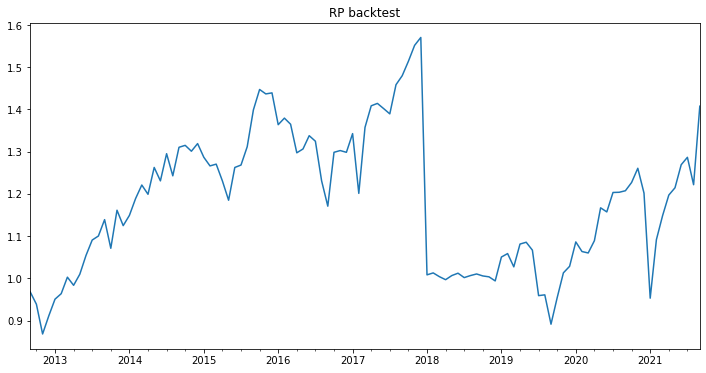

In [169]:
RP_r = backtest_rolling(rets = pd.DataFrame(rets_m_new),obj_fun =erc)
RPcumr_bt= (1+RP_r).cumprod()
RPcumr_bt.plot(figsize=(12,6), title="RP backtest")

In [138]:
rp_bt1 = pd.DataFrame(RP_r,columns=['rp_backtest'])
eri.Summary_Stats(rp_bt1,riskfree_rate=0.0015, periods_per_year=12)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawdown
rp_backtest,-0.002929,0.201277,-1.239544,6.33509,0.108451,0.159411,-0.02199,-0.426747


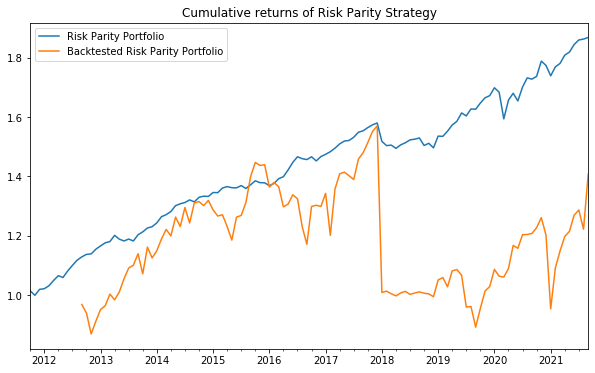

In [170]:
cumrets_RP.plot(figsize = (10,6),title = "Cumulative returns of Risk Parity Strategy",label = 'Risk Parity Portfolio',legend=True)
RPcumr_bt.plot(figsize=(10,6), label="Backtested Risk Parity Portfolio",legend=True)